### Data Analysis
#### Table of Content
1. [Data Overview](#1-data-overview)
1. [Impact of mapping on Latency](#2-impact-of-mapping-on-latency)

In [39]:
# directory_path = 'data/task_5'
# directory_path = 'data/task_10'
directory_path = 'data/task_12'

In [40]:
"""
Importing Generated Data  
"""

import os 
import sys
import pickle 

entries = os.listdir(directory_path)
files = sorted([entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))])

list_of_dict = []
for file_name in files: 
    file_path = os.path.join(directory_path,file_name)
    with open(file_path, 'rb') as file: 
        dict = pickle.load(file)
        list_of_dict.append(dict)
        
print(f"Number of files in \"{directory_path}\": \t{len(files)}")
print(f"Number of files in imported list: \t{len(list_of_dict)}")

Number of files in "data/task_12": 	3600
Number of files in imported list: 	3600


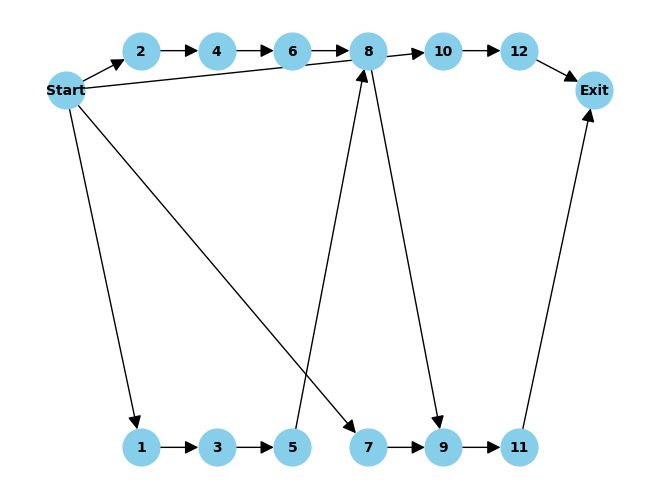

In [41]:
"""
Function for Visualizing Graph Object
"""

import matplotlib.pyplot as plt 
import networkx as nx
import numpy as np

def visGraph(graph, pos=None):
    if pos is None:
        pos = nx.spring_layout(graph, seed=42)
        pos['Start'] = np.array([-1,0])
        pos['Exit'] = np.array([1,0])
    nx.draw(graph, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', arrowsize=20)
    plt.show()

task = list_of_dict[0]
if 'task_graph_pos' in task:
    visGraph(task['task_graph'], pos=task['task_graph_pos'])
else: 
    visGraph(task['task_graph'])

In [42]:
"""
Converting Imported data to Pandas.DataFrame
"""
import pandas as pd 
data_df = pd.DataFrame(list_of_dict)


#### 1. Data overview 

In [43]:

pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("\n\t\t\tFlit Latency (avg) Summary")
print(data_df['avg_flit_lat'].describe())

print("\n\t\t\tPacket Latency (avg) Summary")
print(data_df['avg_packet_lat'].describe())


print("\n\t\t\tNetwork Latency (avg) Summary")
print(data_df['avg_network_lat'].describe())

pd.set_option('display.float_format', None)


			Flit Latency (avg) Summary
count   3600.000
mean      18.717
std        6.773
min        6.273
25%       13.914
50%       17.370
75%       22.142
max       52.132
Name: avg_flit_lat, dtype: float64

			Packet Latency (avg) Summary
count   3600.000
mean      70.558
std       21.199
min       38.139
25%       55.701
50%       66.837
75%       81.533
max      162.904
Name: avg_packet_lat, dtype: float64

			Network Latency (avg) Summary
count         3600.000
mean     163686958.362
std      304093809.561
min             38.712
25%             59.587
50%             78.570
75%      243425064.000
max     1598000128.000
Name: avg_network_lat, dtype: float64


In [44]:
"""
Get Latency Distribution from the number of mapping each task has.
    Given Parameters of the DAG and the demand level, this code will fetch all the mapping and then returns the stats for analysis.
"""

def calculateStats(dataframe, column_names):
    stats_dict = {}
    for column_name in column_names:
        column_range = dataframe[column_name].max() - dataframe[column_name].min()
        column_std_dev = dataframe[column_name].std()
        column_mean = dataframe[column_name].mean()
        column_median = dataframe[column_name].median()
        column_max = dataframe[column_name].max()
        column_min = dataframe[column_name].min()
        
        stats_dict[column_name] = {
            'range': column_range,
            'std': column_std_dev, 
            'mean': column_mean, 
            'median': column_median, 
            'min' : column_min,
            'max' : column_max
        }
    return stats_dict

def plotDualAxis(x, x_label, title, y1, y1_label, y2,  y2_label, log_scale=False):
        fig, ax1 = plt.subplots(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches

        ax1.plot(x, y1, label=y1_label, color='gold')
        if log_scale:
            ax1.set_yscale('log')  # Set log scale for the y-axis on the left
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(y1_label )
        ax1.tick_params('y' )

        ax2 = ax1.twinx()

        ax2.plot(x, y2, label=y2_label, color='cadetblue')
        if log_scale:
            ax2.set_yscale('log')  # Set log scale for the y-axis on the left
        ax2.set_ylabel(y2_label)
        ax2.tick_params('y')

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.title(title)
        # ax1.grid(True, linestyle='--', alpha=0.7)
        # ax2.grid(True, linestyle='--', alpha=0.7)

        fig.tight_layout()
        plt.show()

def getStatFromFilteredDF(demand_df):
    demand_df.reset_index(inplace=True, drop=True)
    demand_df.index += 1

    stats = calculateStats(demand_df, ['avg_packet_lat', 'avg_flit_lat', 'avg_network_lat'])
    return stats

def getMapVariation(data_df,max_out, alpha, beta, demand_level=None):
    filtered_df = data_df.query(f"max_out == {max_out} and alpha == {alpha} and beta == {beta} and demand_level == {demand_level}")
    unique_demand = filtered_df['demand'].apply(tuple).unique() # Returns Unique values of Demand

    unique_lists = [list(t) for t in unique_demand] # List of Unique demand values
    
    stat_list = []
    for unique_list in unique_lists:
        demand_df = filtered_df[filtered_df['demand'].apply(lambda x: set(unique_list).issubset(set(x)))] # Filtering dataframe by looking for similar demand
        stat = getStatFromFilteredDF(demand_df)
        stat_list.append(stat)

    return stat_list

max_out_list = sorted(data_df['max_out'].unique())
alpha_list = sorted(data_df['alpha'].unique())
beta_list = sorted(data_df['beta'].unique())
demand_level_list = sorted(data_df['demand_level'].unique())

print(f"Max Out: \t{max_out_list}")
print(f"Alpha: \t\t{alpha_list}")
print(f"Beta: \t\t{beta_list}")
print(f"Demand Level: \t{demand_level_list}")

mapping_data = []
import copy 
for max_out in max_out_list:
    for alpha in alpha_list:
        for beta in beta_list:
            for demand_level in demand_level_list:
                param = {}
                stat_list = getMapVariation(data_df, max_out, alpha, beta, demand_level) # Returns a list with demandCount size [{avg_packet_lat, avg_flit_lat}, {avg_packet_lat, avg_flit_lat}]
                param['max_out'] = max_out
                param['alpha'] = alpha
                param['beta'] = beta
                param['demand_level'] = demand_level

                for demand_stat in stat_list: # Looping through Demand Counts
                    stat = {}
                    for feature_name in demand_stat: # avg_packet_lat or avg_flit_lat
                        for stat_name in demand_stat[feature_name]: # Range, Std, mean, median, min, max
                            name = feature_name + '_' + stat_name
                            stat[name] = demand_stat[feature_name][stat_name]

                    param = {**param, **stat} # Have to use unpacking operator, otherwise (using update) it creates a reference.? 
                    mapping_data.append(param)


print(f"\nLength of mapping Data {len(mapping_data)}")
mapping_data_df = pd.DataFrame(mapping_data)

Max Out: 	[1, 2, 3, 4, 5]
Alpha: 		[0.5, 1.0, 1.5]
Beta: 		[0.0, 0.5, 1.0, 2.0]
Demand Level: 	[0, 1, 2]

Length of mapping Data 360


#### 2. Impact of mapping on Latency 

In the data-generation process, each time a task graph is created, we perform multiple random mappings (specifically, 10 different mappings) for the same task. In this section, we explore the impact of these random mappings on packet latency. The presented graph clearly illustrates that latency is influenced by the chosen mapping strategies.

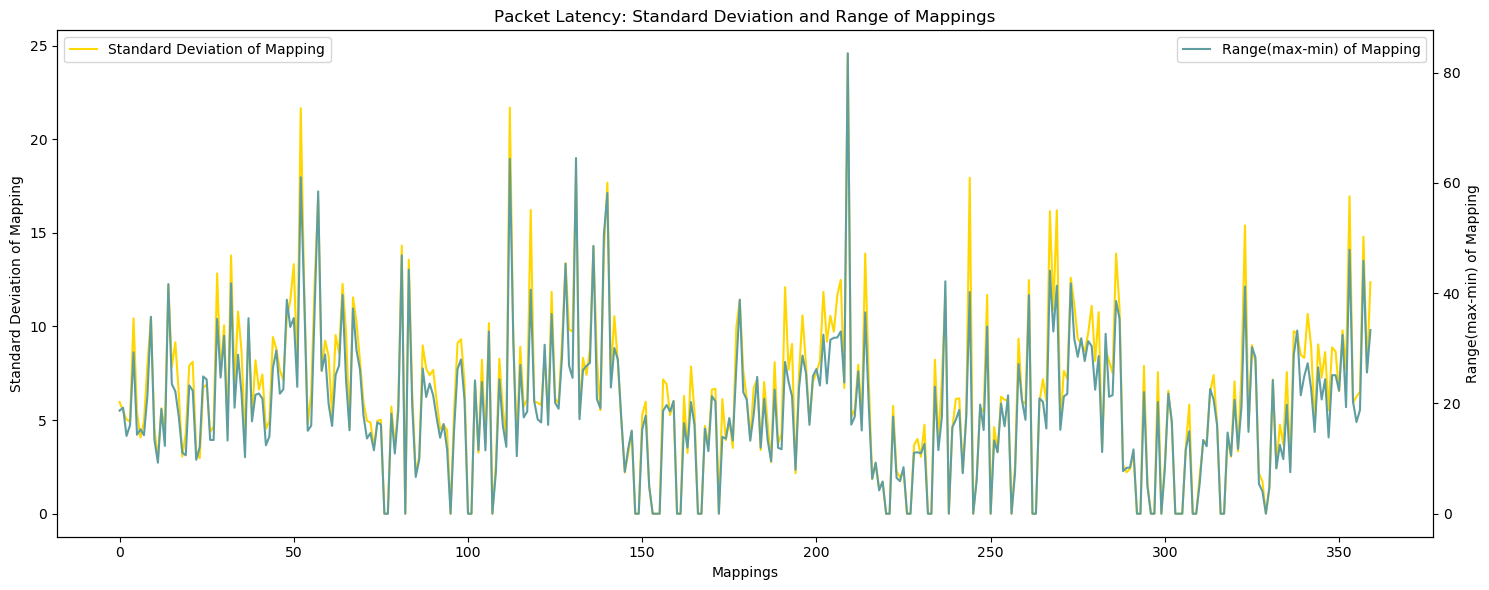

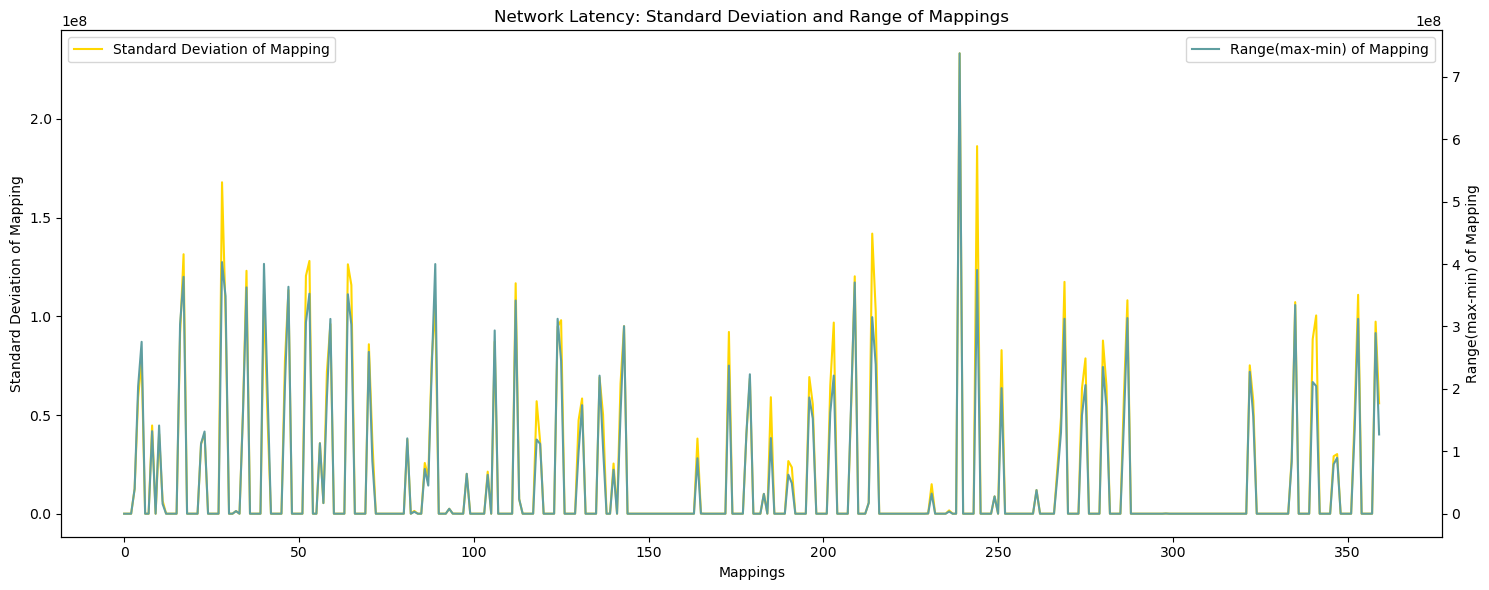

In [50]:
"""
Plot Mapping Data
"""

plotDualAxis(mapping_data_df.index.to_numpy(), 'Mappings', 'Packet Latency: Standard Deviation and Range of Mappings', 
             mapping_data_df['avg_packet_lat_std'].to_numpy(), 'Standard Deviation of Mapping', 
             mapping_data_df['avg_packet_lat_range'].to_numpy(), 'Range(max-min) of Mapping', )

plotDualAxis(mapping_data_df.index.to_numpy(), 'Mappings', 'Network Latency: Standard Deviation and Range of Mappings', 
             mapping_data_df['avg_network_lat_std'].to_numpy(), 'Standard Deviation of Mapping', 
             mapping_data_df['avg_network_lat_range'].to_numpy(), 'Range(max-min) of Mapping', )

In [46]:
display(mapping_data_df)

,max_out,alpha,beta,demand_level,avg_packet_lat_range,avg_packet_lat_std,avg_packet_lat_mean,avg_packet_lat_median,avg_packet_lat_min,avg_packet_lat_max,...,avg_flit_lat_mean,avg_flit_lat_median,avg_flit_lat_min,avg_flit_lat_max,avg_network_lat_range,avg_network_lat_std,avg_network_lat_mean,avg_network_lat_median,avg_network_lat_min,avg_network_lat_max
0,1,0.5,0.0,0,18.708,5.967414,52.1995,50.2215,47.518,66.226,...,13.3502,13.1040,10.226,17.565,1.870800e+01,5.967414e+00,5.219950e+01,5.022150e+01,4.751800e+01,6.622600e+01
1,1,0.5,0.0,0,19.225,5.496378,44.7657,42.6750,39.723,58.948,...,10.9393,10.2520,7.637,13.685,1.922500e+01,5.496378e+00,4.476570e+01,4.267500e+01,3.972300e+01,5.894800e+01
2,1,0.5,0.0,1,14.102,5.031532,65.7884,67.2910,59.199,73.301,...,17.3804,17.0235,14.823,20.932,1.410200e+01,5.031532e+00,6.578840e+01,6.729100e+01,5.919900e+01,7.330100e+01
3,1,0.5,0.0,1,16.047,4.920535,52.0203,52.4745,43.138,59.185,...,13.3467,13.7570,11.187,15.548,3.990002e+07,1.260195e+07,4.830052e+06,5.247450e+01,4.313800e+01,3.990006e+07
4,1,0.5,0.0,2,29.282,10.430284,63.3598,58.9930,51.578,80.860,...,16.4885,16.2595,10.894,22.747,2.039000e+08,5.898622e+07,6.890101e+08,6.658500e+08,6.193000e+08,8.232001e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,5,1.5,2.0,0,16.629,6.250238,64.6317,64.6055,57.013,73.642,...,16.4429,16.5535,12.635,19.907,1.662900e+01,6.250238e+00,6.463170e+01,6.460550e+01,5.701300e+01,7.364200e+01
356,5,1.5,2.0,1,18.815,6.520367,78.7121,78.1580,69.994,88.809,...,20.3993,20.0340,15.918,25.329,1.881500e+01,6.520367e+00,7.871210e+01,7.815800e+01,6.999400e+01,8.880900e+01
357,5,1.5,2.0,1,45.874,14.797076,98.6555,94.0745,80.393,126.267,...,26.5955,26.5390,19.510,32.015,4.587400e+01,1.479708e+01,9.865550e+01,9.407450e+01,8.039300e+01,1.262670e+02
358,5,1.5,2.0,2,25.616,7.589290,58.7253,57.0175,48.629,74.245,...,15.1881,15.5480,8.857,20.823,2.894000e+08,9.730393e+07,1.056401e+08,4.650005e+07,4.630005e+07,3.357001e+08


In [47]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
filtered_mapping_df = mapping_data_df.query(f"max_out == {1} and alpha == {0.5} and beta == {0.0}")
filtered_mapping_df[['avg_packet_lat_mean','avg_flit_lat_mean','avg_network_lat_mean']]

,avg_packet_lat_mean,avg_flit_lat_mean,avg_network_lat_mean
0,52.200,13.350,52.200
1,44.766,10.939,44.766
2,65.788,17.380,65.788
3,52.020,13.347,4830052.074
4,63.360,16.489,689010067.200
5,47.800,11.976,354670043.200
